In [305]:
%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import random
import pandas as pd
from util import util
import numpy as np
import xgboost as xgb
import os
data_folder = os.path.join('..', 'data')
file_name = "DataForModel"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [306]:
import platform
print(platform.architecture())

('64bit', '')


In [307]:
data = util.load_data(data_folder, file_name)
data = data[data['Div'] == 'E0']

data


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,Season,ELO diff,Home_prob_ELO,Draw_prob_ELO,...,Diff_shots_on_target_attempted,Diff_shots_on_target_allowed,Diff_shots_attempted,Diff_shots_allowed,Diff_corners_awarded,Diff_corners_conceded,Diff_fouls_commited,Diff_fouls_suffered,Diff_yellow_cards,Diff_red_cards
0,E0,2005-09-17,Aston Villa,Tottenham,1.0,1.0,0506,-25.173204,0.423508,0.224320,...,-9,10,-14,16,20,18,-13,9,-6,0
1,E0,2005-09-17,Portsmouth,Birmingham,1.0,1.0,0506,6.045620,0.478503,0.202921,...,4,-2,4,-4,0,13,6,17,1,0
2,E0,2005-09-17,Sunderland,West Brom,1.0,1.0,0506,-32.751187,0.410018,0.229569,...,9,-1,-4,8,5,0,-1,-21,-3,1
3,E0,2005-09-18,Blackburn,Newcastle,0.0,3.0,0506,34.014412,0.526477,0.184254,...,1,-13,7,-15,5,-14,0,-2,1,0
4,E0,2005-09-18,Man City,Bolton,0.0,1.0,0506,33.333649,0.525329,0.184700,...,3,3,-8,18,-4,2,-6,-17,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,E0,2024-05-19,Crystal Palace,Aston Villa,5.0,0.0,2324,-90.655703,0.335050,0.213414,...,15,-16,28,-42,5,-5,9,-12,4,1
6251,E0,2024-05-19,Liverpool,Wolves,2.0,0.0,2324,243.468628,0.806489,0.075298,...,22,-6,56,-18,16,-9,-5,-14,-10,0
6252,E0,2024-05-19,Luton,Fulham,2.0,4.0,2324,-112.212233,0.312037,0.198755,...,-4,11,-14,35,7,4,18,10,-1,-1
6253,E0,2024-05-19,Man City,West Ham,3.0,1.0,2324,314.894768,0.864611,0.052681,...,14,-28,2,-59,0,-13,-12,-1,-4,0


In [308]:
data.drop(columns="Div", inplace=True)
from sklearn.preprocessing import LabelEncoder
data = data.copy()
label_encoder = LabelEncoder()

#Convert Date to numerial values
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Day"] = data["Date"].dt.day
data["DayOfWeek"] = data[
    "Date"
].dt.dayofweek  # Optional

# Drop the original Date column as it’s no longer needed
data = data.drop(columns=["Date"])

In [309]:
data = pd.get_dummies(
    data, columns=["HomeTeam", "AwayTeam"]
)

In [310]:
data["Outcome"] = data.apply(
    lambda row: (
        row["FTHG"] - row["FTAG"]
    ),
    axis=1,
)

In [311]:
data

,FTHG,FTAG,Season,ELO diff,Home_prob_ELO,Draw_prob_ELO,Away_prob_ELO,Diff_goals_scored,Diff_goals_conceded,Matchrating,...,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves,Outcome
0,1.0,1.0,0506,-25.173204,0.423508,0.224320,0.352172,0,6,-6,...,False,False,False,True,False,False,False,False,False,0.0
1,1.0,1.0,0506,6.045620,0.478503,0.202921,0.318576,0,-1,1,...,False,False,False,False,False,False,False,False,False,0.0
2,1.0,1.0,0506,-32.751187,0.410018,0.229569,0.360413,-3,-1,-2,...,False,False,False,False,False,True,False,False,False,0.0
3,0.0,3.0,0506,34.014412,0.526477,0.184254,0.289270,2,-2,4,...,False,False,False,False,False,False,False,False,False,-3.0
4,0.0,1.0,0506,33.333649,0.525329,0.184700,0.289971,1,0,1,...,False,False,False,False,False,False,False,False,False,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,5.0,0.0,2324,-90.655703,0.335050,0.213414,0.451536,5,-3,8,...,False,False,False,False,False,False,False,False,False,5.0
6251,2.0,0.0,2324,243.468628,0.806489,0.075298,0.118214,8,-2,10,...,False,False,False,False,False,False,False,False,True,2.0
6252,2.0,4.0,2324,-112.212233,0.312037,0.198755,0.489208,1,8,-7,...,False,False,False,False,False,False,False,False,False,-2.0
6253,3.0,1.0,2324,314.894768,0.864611,0.052681,0.082707,10,-14,24,...,False,False,False,False,False,False,True,False,False,2.0


In [312]:
print("Outcome distribution:")
print(data["Outcome"].value_counts())

Outcome distribution:
Outcome
 0.0    1501
 1.0    1338
-1.0     984
 2.0     893
-2.0     504
 3.0     408
-3.0     231
 4.0     163
-4.0      91
 5.0      76
-5.0      27
 6.0      16
-6.0       7
 7.0       7
 8.0       5
-9.0       1
-7.0       1
 9.0       1
-8.0       1
Name: count, dtype: int64


In [313]:
X = data.copy().drop(
    columns=["Outcome", "FTHG", "FTAG", "Season"]
)  # Drop columns not needed for prediction
y = data.copy()["Outcome"]

from sklearn.model_selection import train_test_split

# Split data into training and test sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

Regressor


In [314]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train,y_train)



RandomForestRegressor(n_estimators=200, random_state=42)

In [315]:
predictions = rf.predict(X_test)

In [316]:
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 2.6800965627498003


Make categories

In [317]:
thresholds = {"hw": 1.5, "hl": -1.5}

def categorize_preds(pred_arr, hw, hl):
    categories = np.where(pred_arr > hw, 1, 
                          np.where((pred_arr <= hw) & (pred_arr > hl), 0, 
                                   -1))
    return np.array(categories)


def categorize_goal_diff(y_test):
    categories = np.where(y_test > 0, 1, 
                        np.where((y_test == 0 ), 0, 
                                -1))
    return np.array(categories)



In [318]:
from sklearn.metrics import classification_report

#categorized_preds = categorize_preds(predictions)
categorized_goal_diff = categorize_goal_diff(y_test)

#report = classification_report(categorize_goal_diff, categorized_preds)


In [319]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize


def optimize_thresholds(pred_arr, truth_arr, hw_range, hl_range):
    best_score = 0
    best_thresholds = thresholds

    # Binarize truth array for multi-class ROC AUC
    truth_binarized = label_binarize(truth_arr, classes=[-1, 0, 1])

    # Iterate over a range of hw and hl values
    for hw in hw_range:
        for hl in hl_range:
            # Predict categories with the current hw and hl
            pred_categories = categorize_preds(pred_arr, hw, hl)
            
            # Binarize predictions for multi-class ROC AUC
            pred_binarized = label_binarize(pred_categories, classes=[-1, 0, 1])
            
            # Calculate macro-average ROC AUC score
            score = roc_auc_score(truth_binarized, pred_binarized, average="macro", multi_class="ovr")
            
            # Update best score and thresholds if current score is better
            if score > best_score:
                best_score = score
                best_thresholds = {"hw": hw, "hl": hl}
    
    
    return best_thresholds

# Example ranges for threshold optimization
hw_range = np.arange(0, 3.01, 0.01)  # Adjust range as needed
hl_range = np.arange(-3, 0.01, 0.01)  # Adjust range as needed



In [320]:
optimal_thresh = optimize_thresholds(predictions, categorized_goal_diff, hw_range, hl_range)

categorized_preds = categorize_preds(predictions,optimal_thresh['hw'], optimal_thresh['hl'])

In [321]:
report = classification_report(categorized_goal_diff, categorized_preds)
print(report)

              precision    recall  f1-score   support

          -1       0.60      0.42      0.49       368
           0       0.30      0.35      0.32       268
           1       0.65      0.73      0.69       615

    accuracy                           0.55      1251
   macro avg       0.52      0.50      0.50      1251
weighted avg       0.56      0.55      0.55      1251



In [322]:
categorized_goal_diff

array([-1,  1,  1, ...,  1,  0,  1])

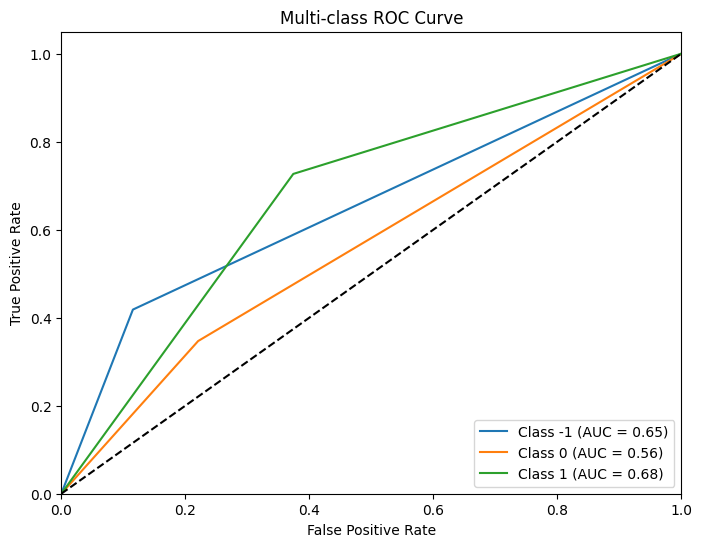

In [323]:
# Categorize the true labels and predictions
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt




# Assuming `categorized_goal_diff` and `categorized_preds` are your 1D arrays
classes = [-1, 0, 1]  # Define the class labels explicitly

# Binarize the true labels and predictions
truth_binarized = label_binarize(categorized_goal_diff, classes=classes)
pred_binarized = label_binarize(categorized_preds, classes=classes)

# Initialize the plot
plt.figure(figsize=(8, 6))

# Calculate ROC curve and AUC for each class
for i, class_label in enumerate(classes):
    # Calculate ROC curve and AUC for the current class
    fpr, tpr, _ = roc_curve(truth_binarized[:, i], pred_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for the current class
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()


